<a href="https://colab.research.google.com/github/juwoncozyboy/MJU_FOM_NLP/blob/main/FOM_NLP_review_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("complaints_processed.csv")
df

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
...,...,...,...
82958,82958,credit_reporting,shocked reviewed credit report found late paym...
82959,82959,credit_reporting,shocked reviewed credit report found late paym...
82960,82960,credit_reporting,shocked reviewed credit report found late paym...
82961,82961,debt_collection,shocked reviewed credit report still found mul...


In [ ]:
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82963 entries, 0 to 82962
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  82963 non-null  int64 
 1   product     82963 non-null  object
 2   narrative   82959 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [ ]:
df.isnull()

,Unnamed: 0,product,narrative
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
82958,False,False,False
82959,False,False,False
82960,False,False,False
82961,False,False,False


In [ ]:
naver_test = pd.read_table('ratings_test.txt',  encoding='utf-8')
naver_train = pd.read_table('ratings_train.txt', encoding='utf-8')

In [ ]:
naver_test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
naver_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
naver_test.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [ ]:
naver_train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [ ]:
naver_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
naver_train.dropna(inplace = True)

In [ ]:
naver_train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
naver_test.dropna(inplace = True)

In [ ]:
naver_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [ ]:
#NLP 파이프 라인
import nltk
from nltk.corpus import stopwords
#stopwords 제거 전 단어를 토큰화 하여야함
#토큰화 후 불용어 처리를 해야함
from nltk.tokenize import word_tokenize

In [ ]:
# 한글과 숫자, 공백, 그리고 일부 특수문자를 제외한 모든 특수문자를 띄어쓰기로 변환
pattern = "[^0-9|ㄱ-ㅎ|ㅏ-ㅣ|가-힣|.,?! ]"
naver_train['document'] = naver_train['document'].replace(pattern, " ", regex=True)
naver_test['document'] = naver_test['document'].replace(pattern, " ", regex=True)

In [ ]:
# 공백 또는 특수문자로만 구성된 데이터 제거
pattern = '^[.,?! ]+$'
naver_train = naver_train.loc[naver_train['document'].str.match(pattern) == False]
naver_test = naver_test.loc[naver_test['document'].str.match(pattern) == False]

In [ ]:
# 공백 또는 특수문자로만 구성된 데이터가 있는지 최종 확인
pattern = '^[.,?! ]+$'
print(naver_train.loc[naver_train['document'].str.match(pattern) == True])
print(naver_test.loc[naver_test['document'].str.match(pattern) == True])

Empty DataFrame
Columns: [id, document, label]
Index: []
Empty DataFrame
Columns: [id, document, label]
Index: []


In [ ]:
print('학습 데이터셋 수 : {}'.format(naver_train.shape[0]))
print('테스트 데이터셋 수 : {}'.format(naver_test.shape[0]))

학습 데이터셋 수 : 148886
테스트 데이터셋 수 : 49630


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.6 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Kkma

In [ ]:
okt = Okt()
kkma = Kkma()

In [ ]:
def tokenizer(choice, sentence):
    okt = Okt()
    kkma = Kkma()
    result = ''  # -> 채워 넣을 sentence 만들기
    morphs = okt.morphs(sentence)
    result = ' '.join(morphs)  # -> 형태소 기준으로 토큰화된 것들 sentence에 넣기
    return result

In [ ]:
print('Okt 토큰화')
print(tokenizer(Okt,"데이터마이닝과 전통적인 기계학습은 실질적으로 같은 의미이다."))  # -> Okt로 토큰화
print('Kkma 토큰화')
print(tokenizer(Kkma,"데이터마이닝과 전통적인 기계학습은 실질적으로 같은 의미이다."))  # -> Kkma 로 토큰화

Okt 토큰화
데이터마이닝 과 전통 적 인 기계학습 은 실질 적 으로 같은 의미 이다 .
Kkma 토큰화
데이터마이닝 과 전통 적 인 기계학습 은 실질 적 으로 같은 의미 이다 .


In [ ]:
def Okt_tagger(dt):
    okt = Okt()
    token_list = [tokenizer(okt,dt.loc[idx, 'document']) for idx in tqdm(dt.index)]
    df_token = pd.Series(token_list, name='document_token', index=dt.index)
    tagged_dt = pd.concat([df_token, dt.label], axis=1)
    return tagged_dt

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!pip install tqdm

In [ ]:
#df_train = Okt_tagger(naver_train)

In [ ]:
df_train = pd.read_csv('nsmc_tokenized_train.csv')

In [ ]:
df_train.head()

,id,document_token,label
0,9976970,아 더빙 .. 진짜 짜증나네요 목소리,0
1,3819312,흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍지 않구나,1
2,10265843,너 무재 밓었 다그 래서 보는것을 추천 한 다,0
3,9045019,교도소 이야기 구먼 .. 솔직히 재미 는 없다 .. 평점 조정,0
4,6483659,사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 ! 스파이더맨 에서 늙어 보이기만...,1


In [ ]:
df_test = pd.read_csv('nsmc_tokenized_test.csv')

In [ ]:
df_test.head()

,id,document_token,label
0,6270596,굳 ㅋ,1
1,8544678,뭐 야 이 평점 들 은 .... 나쁘진 않지만 10 점 짜 리 는 더 더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장 임 ... 돈 주고 보기 에는 ....,0
3,6723715,3 만 아니었어도 별 다섯 개 줬을텐데 .. 왜 3 로 나와서 제 심기 를 불편하게...,0
4,7898805,"음악 이 주가 된 , 최고 의 음악 영화",1


In [ ]:
from sklearn.feature_extraction.text import *

In [ ]:
count = CountVectorizer()
bag = count.fit_transform(df_train['document_token'].values)

print('Vocabulary 길이 : {} 개'.format(len(count.vocabulary_)))
print()

print('토큰화된 단어 200개만 출력 : ')
print(count.get_feature_names_out()[:100])
print(count.get_feature_names_out()[-100:])

Vocabulary 길이 : 97560 개

토큰화된 단어 200개만 출력 : 
['00' '000' '0000000' '000000000' '0000000000000000'
 '00000000000000000000000000000' '000000000000000001' '00000001'
 '0000643652' '0001' '0002027146' '0007' '000달러' '000원' '001' '003' '005'
 '007' '007년' '007시' '009' '00년' '00시' '01' '010' '011' '01410' '01년' '02'
 '02년' '03' '03년' '03분' '04' '047' '04년' '04월' '05' '05년' '06' '06년' '06월'
 '07' '07년' '08' '08년' '08일' '09' '09년' '0원' '10' '100' '1000' '10000'
 '100000' '1000000' '10000000' '100000000' '1000000000'
 '100000000000000000000000000000000000000000000000000000' '1000000000만'
 '10000원' '1000년' '1000만' '1000억' '1000억원' '1000원' '1001' '100187356829'
 '100987' '100년' '100만' '100만분' '100만원' '100분' '100억' '100원' '100일' '100회'
 '101' '1010' '101010' '10101010' '1010101010' '101010101010'
 '10101010101010' '1016' '101분' '102' '1025' '1026' '102분' '102회' '103'
 '103분' '10403' '10429' '10432' '105분' '106']
['힘들어하지' '힘들엇네' '힘들엇다' '힘들었' '힘들었겠' '힘들었겠구만' '힘들었겠다' '힘들었겠다는' '힘들었겠음'
 '힘들었겠지' '힘들었고' 

# EDA Process
1. okt_tagger를 사용해 train, test 토큰화하기
2. CountVectorizer 사용해 BOW (Bag Of Words)만들기
- 2번 코드
count = CountVectorizer()
bag = count.fit_transform(df_train['document_token'].values)

print('Vocabulary 길이 : {} 개'.format(len(count.vocabulary_)))
print()

print('토큰화된 단어 200개만 출력 : ')
print(count.get_feature_names_out()[:100])
print(count.get_feature_names_out()[-100:])

3. 문장 속 단어의 길이가 2개 이하인 문장은 drop 시키기
4. 3번을 제외한 다른 전처리 하나씩 해보기
   -> 문장 길이에 대한 전처리가 아니여도 괜찮음
   -> 구글링 및 검색 (당연히 지피티도 가능)을 통해 찾아보기!!
       ex) 한국어 nlp 전처리, 네이버 영화 리뷰 코드 등등
5. 4번까지 수행 후 전처리 된 데이터를 활용해 모델링 진행
   -> 모델링 전 encoding할 method도 고민하기
       ex) TF-IDF, Word2Vec, LSA 등등
6. 모델 학습 후 성능 평가 및 하이퍼 파라미터 튜닝 할 수 있으면 해보기


위의 내용들은 여러분들이 해주시면 좋겠는 저의 과제입니다!! 제 생각에는 모델링 전까지는 스스로 하실 수 있을거 같은데 모델링부터는 제가 하거나 저의 도움을 받아서 진행하도록 하겠습니다!!

그리고 미니 프로젝트 진행을 위해 주말에 줌 회의를 한 번 할려고합니다.
가능하신 시간대 각자 모두 알려주세요~~ 그렇게 오래하지는 않을거 같은데 30분 이상은 생각하셔야합니다!!

In [ ]:
#단어 갯수 2개 이하의 인덱스
words=bag.sum(axis=1)
print(words.shape)
row_index = np.array(np.where(words<=2)[0])

(145497, 1)


In [ ]:
df_filtered=df_train.drop(df_train.index[row_index])
print(df_filtered.shape)

(130600, 3)


# 모델링 진행

In [ ]:
#sklearn 사용해서 토큰화된 문장 변환
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [ ]:
# 평가 지표 정의하기
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, \
                            confusion_matrix, classification_report

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()


In [ ]:
X_train = vectorizer.fit_transform(df_filtered['document_token'])
y_train = df_filtered['label'].values
X_test = vectorizer.transform(df_test['document_token'])
y_test = df_test['label'].values

In [ ]:
# 평가 지표 정의하기
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, \
                            confusion_matrix, classification_report

In [ ]:
# 학습데이터로 모델 학습하기
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

# 테스트데이터에 대한 y값 예측하기
y_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 성능 평가하기

# Model Accuracy
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))

# Generate Confusion Matrix and Classification Report
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))


Accuracy: 0.838

[[20686  3677]
 [ 4230 20310]]

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     24363
           1       0.85      0.83      0.84     24540

    accuracy                           0.84     48903
   macro avg       0.84      0.84      0.84     48903
weighted avg       0.84      0.84      0.84     48903



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torchvision.models as models

# MPS 장치 확인 및 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


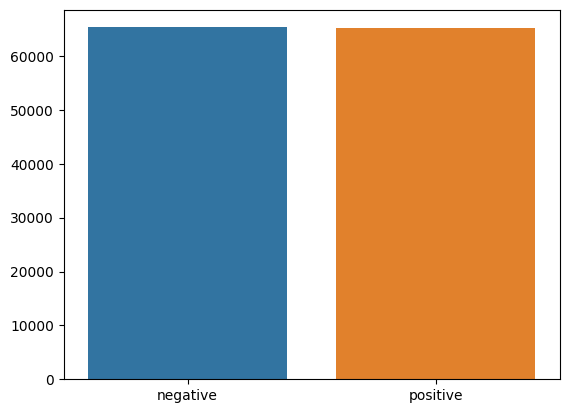

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [ ]:
print(X_train.shape)

(130600, 95986)


In [ ]:
print(X_test.shape)

(48903, 95986)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(130600,)
(48903,)


In [ ]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
no_layers = 2
vocab_size = len(count.vocabulary_) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = ConvLSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

TypeError: ignored

In [ ]:
conv_lstm_model = ConvLSTMCell(input_dim, hidden_dim, kernel_size, num_layers, batch_first, bias, return_all_layers)

NameError: ignored

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1):

    train_loss = 0
    model.train()
    for batch_num, (input, target) in enumerate(train_loader, 1):
        output = model(input)
        loss = criterion(output.flatten(), target.flatten())
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for input, target in val_loader:
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            val_loss += loss.item()
    val_loss /= len(val_loader.dataset)

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))

NameError: ignored

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out.view(len(x), -1))
        return predictions




In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden



In [ ]:
no_layers = 2
vocab_size = len(count.vocabulary_) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

In [ ]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
# 스파스 행렬을 밀집 행렬로 변환
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# DataLoader 설정
#train_loader = DataLoader(torch.tensor(X_train_dense, dtype=torch.float32), batch_size=10, shuffle=True)
#val_loader = DataLoader(torch.tensor(X_test_dense, dtype=torch.float32), batch_size=10, shuffle=False)


In [ ]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# 데이터 로더 설정 (예시)
train_loader = DataLoader(X_train_dense, batch_size=10, shuffle=True)
val_loader = DataLoader(X_test_dense, batch_size = 10, shuffle=False)

# 모델, 손실 함수, 옵티마이저 설정
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.011)



In [ ]:
# 훈련 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    for epoch in range(n_epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for inputs in train_loader:
            for labels in train_loader:

                inputs, labels = inputs.to(device), labels.to(device)
                hidden = model.init_hidden(inputs.size(0))

                optimizer.zero_grad()
                output, hidden = model(inputs, hidden)
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_acc += ((output.squeeze() > 0.5) == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = total_acc / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

        model.eval()
        total_loss, total_acc = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                hidden = model.init_hidden(inputs.size(0))

                output, hidden = model(inputs, hidden)
                loss = criterion(output.squeeze(), labels.float())

                total_loss += loss.item()
                total_acc += ((output.squeeze() > 0.5) == labels).sum().item()

        val_loss = total_loss / len(val_loader)
        val_acc = total_acc / len(val_loader.dataset)
        print(f'Epoch {epoch + 1}/{n_epochs} - Validation loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')






In [ ]:


# 모델 훈련 함수 실행
n_epochs = 30  # 에폭 수
train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs)
